<a href="https://colab.research.google.com/github/jyotidabass/LSTM/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Unduh dataset (https://www.kaggle.com/yufengdev/bbc-fulltext-and-category)
!wget --no-check-certificate \
https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv \-O /tmp/bbc-text.csv

--2022-04-22 04:34:14--  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.128, 74.125.23.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.03s   

2022-04-22 04:34:15 (160 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [2]:
# Persiapkan dataset
import pandas as pd
df = pd.read_csv('/tmp/bbc-text.csv')
df = df[['text', 'category']]
df

,text,category
0,tv future in the hands of viewers with home th...,tech
1,worldcom boss left books alone former worldc...,business
2,tigers wary of farrell gamble leicester say ...,sport
3,yeading face newcastle in fa cup premiership s...,sport
4,ocean s twelve raids box office ocean s twelve...,entertainment
...,...,...
2220,cars pull down us retail figures us retail sal...,business
2221,kilroy unveils immigration policy ex-chatshow ...,politics
2222,rem announce new glasgow concert us band rem h...,entertainment
2223,how political squabbles snowball it s become c...,politics


In [3]:
df.iloc[1000]['text']

'parties warned over  grey vote  political parties cannot afford to take older uk voters for granted in the coming election  says age concern.  a survey for the charity suggests 69% of over-55s say they always vote in a general election compared with just 17% of 18 to 24 year olds. charity boss gordon lishman said if a  decisive blow  was struck at the election it would be by older voters who could be relied on to turn out. a total of 3 028 adults aged 18 or over were interviewed for the study. mr lishman urged the next government to boost state pension.  he also called for measures to combat ageism and build effective public services to  support us all in an ageing society .  older people want to see manifesto commitments that will make a difference to their lives   mr lishman said.  political parties must wake up to the fact that unless they address the demands and concerns of older people they will not keep or attract their vote.  in the survey carried out by icm research  14% of pe

In [4]:
# One-hot-encoding label
category = pd.get_dummies(df.category)
new_df = pd.concat([df, category], axis=1)
new_df = new_df.drop(columns='category')
new_df

,text,business,entertainment,politics,sport,tech
0,tv future in the hands of viewers with home th...,0,0,0,0,1
1,worldcom boss left books alone former worldc...,1,0,0,0,0
2,tigers wary of farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle in fa cup premiership s...,0,0,0,1,0
4,ocean s twelve raids box office ocean s twelve...,0,1,0,0,0
...,...,...,...,...,...,...
2220,cars pull down us retail figures us retail sal...,1,0,0,0,0
2221,kilroy unveils immigration policy ex-chatshow ...,0,0,1,0,0
2222,rem announce new glasgow concert us band rem h...,0,1,0,0,0
2223,how political squabbles snowball it s become c...,0,0,1,0,0


In [5]:
# Ubah dataframe ke tipe data numpy array
texts = new_df['text'].values
label = new_df[['business', 'entertainment', 'politics', 'sport', 'tech']].values

# Bagi train set dan test set
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_label, test_label = train_test_split(texts, label, test_size=0.2)

In [6]:
# Stopword removal dan porter steemming teks
import numpy as np
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords

porterStemmer = PorterStemmer()

fixed_train_texts = []
for text in train_texts:
  removed_text = remove_stopwords(text)   # Stopword removal
  removed_text = porterStemmer.stem_sentence(removed_text) # Port steemming
  fixed_train_texts.append(removed_text)

fixed_train_texts = np.array(fixed_train_texts, dtype='O')   # Train set 

fixed_test_texts = []
for text in test_texts:
  removed_text = remove_stopwords(text)
  removed_text = porterStemmer.stem_sentence(removed_text) # Port steemming
  fixed_test_texts.append(removed_text)

fixed_test_texts = np.array(fixed_test_texts, dtype='O')  # Test set


In [7]:
print(f'text ({len(train_texts[0])}): {train_texts[0]}')
print(f'removed ({len(fixed_train_texts[0])}): {fixed_train_texts[0]} ({len(fixed_train_texts[0])})')

text (973): hacker threat to apple s itunes users of apple s music jukebox itunes need to update the software to avoid a potential security threat.  hackers can build malicious playlist files which could crash the program and let them seize control of the computer by inserting trojan code. a new version of itunes is now available from the apple website which solves the problem. security firm idefence  which notified users of the problem  recommended that users upgrade to itunes version 4.7.1. the problem affects all users of itunes - windows and mac os - running versions 4.7 and earlier. users can automatically upgrade itunes by opening the  look for updates  window in the program. the security firm says users should avoid clicking on or accessing playlist files - which have the file extension of .pls or .m3u - which have come from unknown sources. itunes is the world s most popular online music store with more than 200 million songs downloaded since it launched in 2003.
removed (618):

In [8]:
# Tokenisasi teks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(fixed_train_texts)
tokenizer.fit_on_texts(fixed_test_texts)
print(tokenizer.word_index)

{'x': 2258, 's': 2, 'said': 3, 'year': 4, 'mr': 5, 'new': 6, 'peopl': 7, 'game': 8, 'time': 9, 't': 10, 'like': 11, 'world': 12, 'govern': 13, 'film': 14, 'plai': 15, 'uk': 16, 'work': 17, 'compani': 18, 'firm': 19, 'best': 20, 'want': 21, 'win': 22, 'music': 23, 'told': 24, 'market': 25, 'number': 26, 'set': 27, 'sai': 28, 'come': 29, 'us': 30, 'includ': 31, 'plan': 32, 'labour': 33, '000': 34, 'month': 35, '1': 36, 'wai': 37, 'look': 38, 'need': 39, 'report': 40, 'bbc': 41, 'week': 42, 'servic': 43, 'player': 44, 'expect': 45, 'parti': 46, 'home': 47, 'good': 48, 'think': 49, 'sale': 50, '2': 51, 'countri': 52, 'minist': 53, 'million': 54, 'help': 55, 'second': 56, 'right': 57, 'go': 58, 'nation': 59, 'mobil': 60, 'elect': 61, 'end': 62, '2004': 63, 'start': 64, 'record': 65, 'open': 66, 'dai': 67, 'technolog': 68, 'group': 69, 'england': 70, '6': 71, 'gener': 72, 'offer': 73, 'blair': 74, 'public': 75, 'won': 76, 'award': 77, 'claim': 78, 'phone': 79, 'high': 80, 'share': 81, 'star'

In [9]:
# Sekuensi sampel 
train_sequences = tokenizer.texts_to_sequences(fixed_train_texts)
test_sequences = tokenizer.texts_to_sequences(fixed_test_texts)

# Padding sekuen
padded_train = pad_sequences(train_sequences)
padded_test = pad_sequences(test_sequences)

In [10]:
# Buat arsitektur model ANN
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Tentukan optimizer dan loss function model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          80000     
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 117,637
Trainable params: 117,637
Non-trainable params: 0
_________________________________________________________________


In [11]:
class modelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
my_callback = modelCallback()

In [12]:
# Latih model
hist = model.fit(
    padded_train, train_label,
    validation_data=(padded_test, test_label),
    epochs=20,
    batch_size=128,
    verbose=2,
    callbacks=[my_callback])

Epoch 1/20
14/14 - 37s - loss: 1.6060 - accuracy: 0.2258 - val_loss: 1.6030 - val_accuracy: 0.2022 - 37s/epoch - 3s/step
Epoch 2/20
14/14 - 34s - loss: 1.5804 - accuracy: 0.2888 - val_loss: 1.5172 - val_accuracy: 0.3169 - 34s/epoch - 2s/step
Epoch 3/20
14/14 - 34s - loss: 1.5136 - accuracy: 0.4483 - val_loss: 1.4803 - val_accuracy: 0.4787 - 34s/epoch - 2s/step
Epoch 4/20
14/14 - 34s - loss: 1.3521 - accuracy: 0.5663 - val_loss: 1.1928 - val_accuracy: 0.5101 - 34s/epoch - 2s/step
Epoch 5/20
14/14 - 35s - loss: 0.9187 - accuracy: 0.6090 - val_loss: 0.7794 - val_accuracy: 0.6000 - 35s/epoch - 3s/step
Epoch 6/20
14/14 - 34s - loss: 0.6259 - accuracy: 0.7584 - val_loss: 0.7395 - val_accuracy: 0.6966 - 34s/epoch - 2s/step
Epoch 7/20
14/14 - 33s - loss: 0.4141 - accuracy: 0.8730 - val_loss: 0.5194 - val_accuracy: 0.8090 - 33s/epoch - 2s/step
Epoch 8/20

Akurasi telah mencapai >90%!
14/14 - 33s - loss: 0.2289 - accuracy: 0.9326 - val_loss: 0.5252 - val_accuracy: 0.8292 - 33s/epoch - 2s/step


<function matplotlib.pyplot.show>

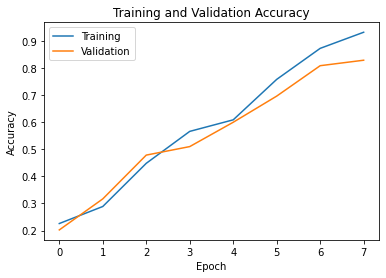

In [13]:
# Plot akurasi model
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show

<function matplotlib.pyplot.show>

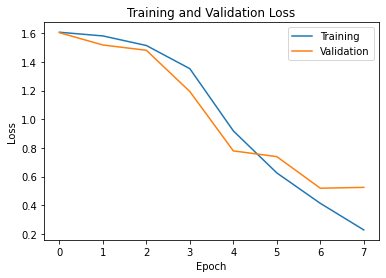

In [14]:
# Plot loss model
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show